In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Kaggle's Cats vs Dogs**
Download our cats vs dogs dataset. Should talk around 15-20 seconds.
Source - https://www.kaggle.com/c/dogs-vs-cats/data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp "/content/drive/MyDrive/Computer Vision/dogs-vs-cats.zip" /content/


In [5]:
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip

In [6]:
# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [7]:
print(train_files[:10])
print(test_files[:10])

['cat.1841.jpg', 'cat.6502.jpg', 'cat.8978.jpg', 'cat.11912.jpg', 'cat.10963.jpg', 'dog.4542.jpg', 'dog.6216.jpg', 'cat.5495.jpg', 'cat.35.jpg', 'cat.334.jpg']
['8223.jpg', '4052.jpg', '11221.jpg', '8751.jpg', '1568.jpg', '7498.jpg', '4609.jpg', '7016.jpg', '11420.jpg', '10792.jpg']


In [ ]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [ ]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/cat.7410.jpg


#### **Create our transformations**

In [8]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

## **Create a Dataset class that stores our dataset information (paths, labels and transformations**

This object can then be utilzied by torch functions such as `torch.utils.data.random_split`

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [9]:
class Dataset():
    def __init__(self, filelist, filepath, transform = None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)

        if "dog" in imgpath:
            label = 1
        else:
            label = 0

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [10]:
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

### **Using our dataset Object**

In [ ]:
# Getting a data entry
train.__getitem__(0)

(tensor([[[0.3961, 0.3961, 0.3961,  ..., 0.1255, 0.1882, 0.2745],
          [0.4039, 0.4000, 0.3843,  ..., 0.1647, 0.2549, 0.2980],
          [0.4039, 0.4078, 0.3333,  ..., 0.2392, 0.3059, 0.3176],
          ...,
          [0.2824, 0.2784, 0.2824,  ..., 0.3255, 0.2902, 0.2863],
          [0.2863, 0.2824, 0.2824,  ..., 0.3137, 0.2941, 0.2902],
          [0.2902, 0.2902, 0.2902,  ..., 0.3098, 0.2980, 0.2902]],
 
         [[0.4314, 0.4314, 0.4314,  ..., 0.1333, 0.1569, 0.2275],
          [0.4392, 0.4353, 0.4196,  ..., 0.1686, 0.2235, 0.2471],
          [0.4392, 0.4431, 0.3686,  ..., 0.2235, 0.2745, 0.2706],
          ...,
          [0.3373, 0.3333, 0.3294,  ..., 0.3529, 0.3294, 0.3333],
          [0.3412, 0.3373, 0.3373,  ..., 0.3451, 0.3333, 0.3333],
          [0.3451, 0.3451, 0.3451,  ..., 0.3529, 0.3412, 0.3333]],
 
         [[0.4510, 0.4510, 0.4510,  ..., 0.1137, 0.1529, 0.2275],
          [0.4588, 0.4549, 0.4392,  ..., 0.1490, 0.2157, 0.2471],
          [0.4588, 0.4588, 0.3804,  ...,

In [ ]:
# Getting the shape of a single image
print(val.__getitem__(0)[0].shape)
print(train.__getitem__(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


## **Using our dataset object to create our train, validation split**

In [11]:
train, val = torch.utils.data.random_split(train,[20000,5000])

In [12]:
# Getting a size of our
print(len(train))
print(len(val))

20000
5000


In [13]:
# Let's create an array of our labels
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

In [14]:
val_set_class_count[:10]

[1, 0, 1, 0, 1, 0, 0, 0, 0, 1]

<Axes: ylabel='count'>

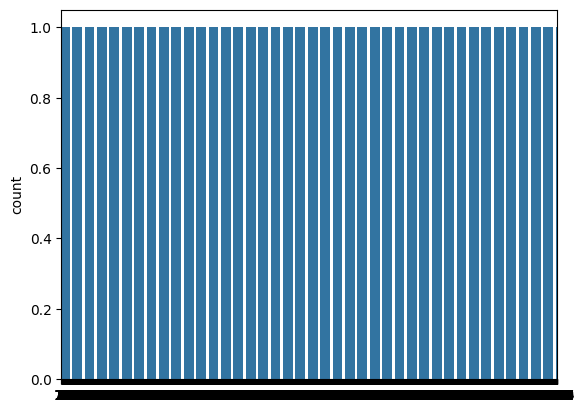

In [ ]:
import seaborn as sns

sns.countplot(val_set_class_count)

## **Dataloaders - let's create our iterable over a dataset**

In [15]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

### **Use it to get some sample images**

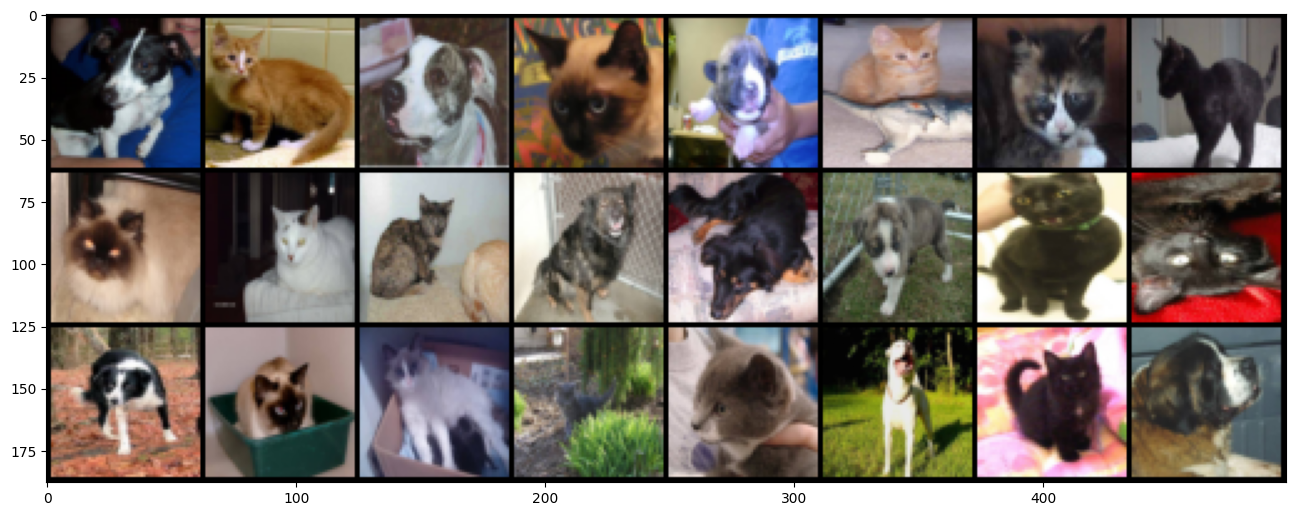

In [17]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

**Now we build our Model**

We will use the ```nn.Sequential``` method to construct our model. Alernatively we can use the functional module, however this is simpler and more similar to styles you'll work with in Keras.

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            )

        self.conv2 =   nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv3 =   nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*5*5,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU()
        )

        self.fc2 = nn.Sequential(
        nn.Linear(128,2),
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x,dim = 1)

In [19]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### **Defining a Loss Function and Optimizer**

We need to define what type of loss we'll be using and what method will be using to update the gradients.
1. We use Cross Entropy Loss
2. We use the Adam Optimization Descent Algorithm - we also specify a learn rate (LR) of 0.0005.
3. Set our epochs to 50

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

## **Train our Model**

**We use TQDM to perform a keras style training**


In [ ]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step()

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-22-ed1d14d94d43>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.57905
Epoch 1 Training Loss = 21.443504069519044
Epoch 1 Validation Accuracy = 0.6588
Epoch 1 Validation Loss = 19.945079663756548


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6881
Epoch 2 Training Loss = 19.186641969299316
Epoch 2 Validation Accuracy = 0.7116
Epoch 2 Validation Loss = 18.538675976406996


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.72695
Epoch 3 Training Loss = 18.179883267211913
Epoch 3 Validation Accuracy = 0.7312
Epoch 3 Validation Loss = 18.00275918632556


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.7471
Epoch 4 Training Loss = 17.607374882507326
Epoch 4 Validation Accuracy = 0.7414
Epoch 4 Validation Loss = 17.670375508107956


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.7675
Epoch 5 Training Loss = 17.04469552307129
Epoch 5 Validation Accuracy = 0.7548
Epoch 5 Validation Loss = 17.25102536389782


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.7841
Epoch 6 Training Loss = 16.55168017272949
Epoch 6 Validation Accuracy = 0.766
Epoch 6 Validation Loss = 17.04461781993793


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.79295
Epoch 7 Training Loss = 16.262363610839845
Epoch 7 Validation Accuracy = 0.7708
Epoch 7 Validation Loss = 16.78618486367973


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.80795
Epoch 8 Training Loss = 15.868413102722167
Epoch 8 Validation Accuracy = 0.779
Epoch 8 Validation Loss = 16.6569770673278


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.822
Epoch 9 Training Loss = 15.465286651611327
Epoch 9 Validation Accuracy = 0.781
Epoch 9 Validation Loss = 16.66778335449802


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.83195
Epoch 10 Training Loss = 15.167584649658203
Epoch 10 Validation Accuracy = 0.7874
Epoch 10 Validation Loss = 16.350894177795215


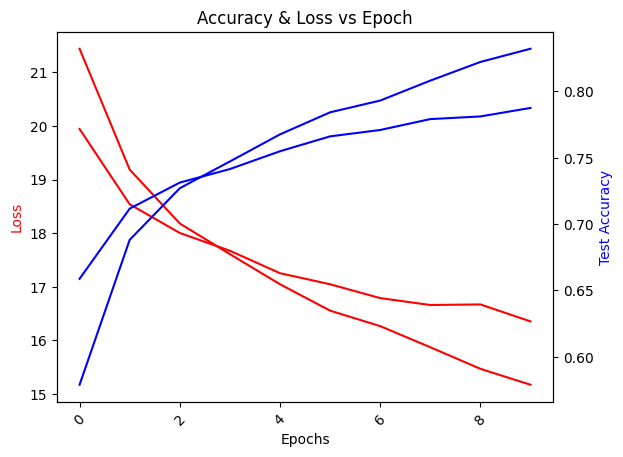

In [ ]:
epoch_log = [*range(epochs)]

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [ ]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

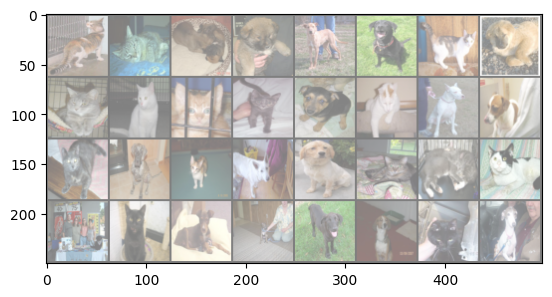

GroundTruth:  00111101000010110101100000111101


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Loading one mini-batch
dataiter = iter(val_dataset)
images, labels = next(dataiter)

# Display images using torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s' % labels[j].numpy() for j in range(32)))

In [ ]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
model = CNN()
model.to(device)

# Load weights from the specified path
model.load_state_dict(torch.load(PATH))

<ipython-input-29-f99326926dc1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

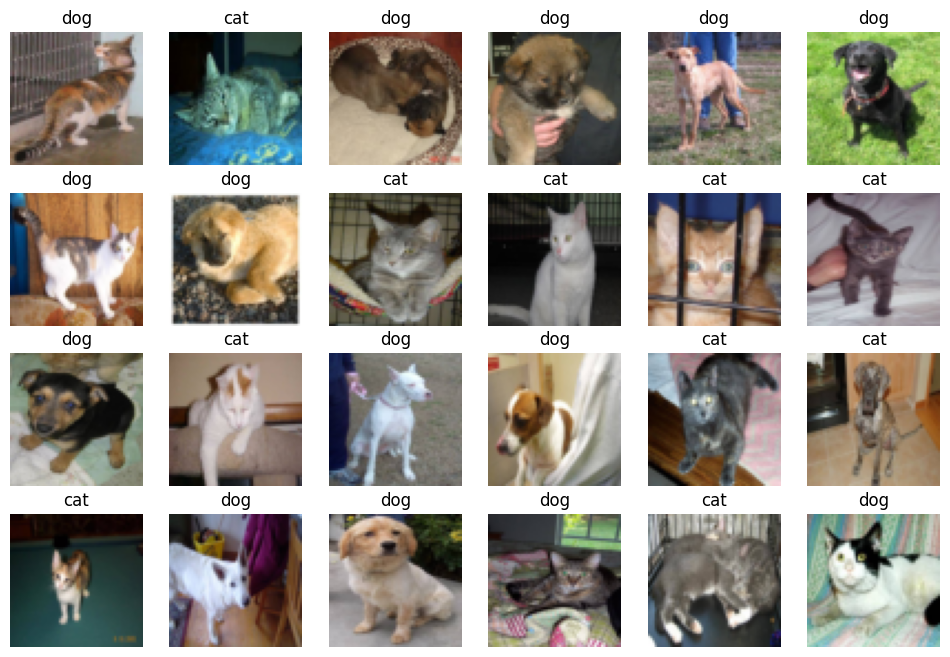

In [ ]:
samples, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))